In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NonStationaryBandit:
    def __init__(self, k=10, mu=0, sigma=0.01):
        self.k = k
        self.mu = mu
        self.sigma = sigma
        self.q_star = np.zeros(k)

    def step(self):
        # Update true action values
        self.q_star += np.random.normal(self.mu, self.sigma, self.k)

    def pull(self, action):
        return np.random.normal(self.q_star[action], 1)

In [3]:
class SampleAverageAgent:
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k)
        self.N = np.zeros(k)

    def choose_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.Q)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

In [4]:
class ConstantStepSizeAgent:
    def __init__(self, k, epsilon, alpha):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros(k)

    def choose_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.Q)

    def update(self, action, reward):
        self.Q[action] += self.alpha * (reward - self.Q[action])

In [5]:
class UCBAgent:
    def __init__(self, k, c):
        self.k = k
        self.c = c
        self.Q = np.zeros(k)
        self.N = np.zeros(k)
        self.t = 0

    def choose_action(self):
        self.t += 1
        
        # Case where some actions haven't been selected yet
        if np.any(self.N == 0):
            return np.argmin(self.N)
        
        UCB = self.Q + self.c * np.sqrt(np.log(self.t) / self.N)
        
        return np.argmax(UCB)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

In [6]:
class GradientBanditAgent:
    def __init__(self, k, alpha):
        self.k = k
        self.alpha = alpha
        self.H = np.zeros(k)
        self.pi = np.ones(k) / k
        self.average_reward = 0
        self.t = 0

    def choose_action(self):
        return np.random.choice(self.k, p=self.pi)

    def update(self, action, reward):
        self.t += 1

        # Update average reward
        self.average_reward += (reward - self.average_reward) / self.t
        
        # Compute the change for all actions
        delta = self.alpha * (reward - self.average_reward) * (np.arange(self.k) == action - self.pi)

        # Update preferences
        self.H += delta

        # Recompute action probabilities
        self.pi = np.exp(self.H) / np.sum(np.exp(self.H))

In [7]:
class OptimisticInitializationAgent:
    def __init__(self, k, epsilon, alpha, initial_value):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.full(k, initial_value)  # Optimistic initialization

    def choose_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.Q)

    def update(self, action, reward):
        self.Q[action] += self.alpha * (reward - self.Q[action])

In [11]:
def run_experiment(agent_class, agent_params, num_steps=200000, num_runs=2000):
    print(f'Agent class {agent_class} with params {agent_params}')
    total_reward = 0
    for run in range(num_runs):
        agent = agent_class(**agent_params)
        bandit = NonStationaryBandit()
        for t in range(num_steps):
            bandit.step()
            action = agent.choose_action()
            reward = bandit.pull(action)
            agent.update(action, reward)
            if t >= num_steps - 100000:
                total_reward += reward
        if (run + 1) % 200 == 0:
            print(f'Average reward for last 100,000 steps in {run + 1} runs: {total_reward / ((run + 1) * 100000)}')
    avg_reward = total_reward / (num_runs * 100000)
    print(f'Average reward over {num_runs} runs for {num_steps} steps: {avg_reward}')
    return avg_reward

In [12]:
# Parameters to test
epsilons = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]
alphas = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
cs = [1/16, 1/8, 1/4, 1/2, 1, 2, 4]
initial_values = [1/4, 1/2, 1, 2, 4]

In [13]:
sample_average_rewards = [run_experiment(SampleAverageAgent, {'k': 10, 'epsilon': epsilon}) for epsilon in epsilons]

Agent class <class '__main__.SampleAverageAgent'> with params {'k': 10, 'epsilon': 0.0078125}
Average reward for last 100,000 steps in 200 runs: 4.735315254462838
Average reward for last 100,000 steps in 400 runs: 4.602995569646722
Average reward for last 100,000 steps in 600 runs: 4.574839511173733
Average reward for last 100,000 steps in 800 runs: 4.59658498087131
Average reward for last 100,000 steps in 1000 runs: 4.609605503741235
Average reward for last 100,000 steps in 1200 runs: 4.5701044304327665
Average reward for last 100,000 steps in 1400 runs: 4.5956384701407496
Average reward for last 100,000 steps in 1600 runs: 4.580858033510876
Average reward for last 100,000 steps in 1800 runs: 4.582845951316014
Average reward for last 100,000 steps in 2000 runs: 4.569484202490048
Average reward over 2000 runs for 200000 steps: 4.569484202490048
Agent class <class '__main__.SampleAverageAgent'> with params {'k': 10, 'epsilon': 0.015625}
Average reward for last 100,000 steps in 200 runs:

In [14]:
epsilon_greedy_01_rewards = [run_experiment(ConstantStepSizeAgent, {'k': 10, 'epsilon': epsilon, 'alpha': 0.1}) for epsilon in epsilons]

Agent class <class '__main__.ConstantStepSizeAgent'> with params {'k': 10, 'epsilon': 0.0078125, 'alpha': 0.1}
Average reward for last 100,000 steps in 200 runs: 5.958861521709356
Average reward for last 100,000 steps in 400 runs: 5.932036021708229
Average reward for last 100,000 steps in 600 runs: 5.931411266136247
Average reward for last 100,000 steps in 800 runs: 5.941791790269577
Average reward for last 100,000 steps in 1000 runs: 5.930137031347089
Average reward for last 100,000 steps in 1200 runs: 5.9300493158040295
Average reward for last 100,000 steps in 1400 runs: 5.948724337392838
Average reward for last 100,000 steps in 1600 runs: 5.9669294360197
Average reward for last 100,000 steps in 1800 runs: 5.979171769701188
Average reward for last 100,000 steps in 2000 runs: 5.941013697255185
Average reward over 2000 runs for 200000 steps: 5.941013697255185
Agent class <class '__main__.ConstantStepSizeAgent'> with params {'k': 10, 'epsilon': 0.015625, 'alpha': 0.1}
Average reward for

In [15]:
epsilon_greedy_001_rewards = [run_experiment(ConstantStepSizeAgent, {'k': 10, 'epsilon': epsilon, 'alpha': 0.01}) for epsilon in epsilons]


Agent class <class '__main__.ConstantStepSizeAgent'> with params {'k': 10, 'epsilon': 0.0078125, 'alpha': 0.01}
Average reward for last 100,000 steps in 200 runs: 5.164952015238727
Average reward for last 100,000 steps in 400 runs: 5.194975294753359
Average reward for last 100,000 steps in 600 runs: 5.236093813726955
Average reward for last 100,000 steps in 800 runs: 5.253533799808927
Average reward for last 100,000 steps in 1000 runs: 5.240570047134058
Average reward for last 100,000 steps in 1200 runs: 5.2189427936791795
Average reward for last 100,000 steps in 1400 runs: 5.225780721201252
Average reward for last 100,000 steps in 1600 runs: 5.211883261002906
Average reward for last 100,000 steps in 1800 runs: 5.222181659825637
Average reward for last 100,000 steps in 2000 runs: 5.234951674742868
Average reward over 2000 runs for 200000 steps: 5.234951674742868
Agent class <class '__main__.ConstantStepSizeAgent'> with params {'k': 10, 'epsilon': 0.015625, 'alpha': 0.01}
Average reward

In [16]:
ucb_rewards = [run_experiment(UCBAgent, {'k': 10, 'c': c}) for c in cs]

Agent class <class '__main__.UCBAgent'> with params {'k': 10, 'c': 0.0625}
Average reward for last 100,000 steps in 200 runs: 2.6123313257427134
Average reward for last 100,000 steps in 400 runs: 2.7201747760623856
Average reward for last 100,000 steps in 600 runs: 2.643891551535669
Average reward for last 100,000 steps in 800 runs: 2.6561818200861493
Average reward for last 100,000 steps in 1000 runs: 2.6573107924009074
Average reward for last 100,000 steps in 1200 runs: 2.6592188872129894
Average reward for last 100,000 steps in 1400 runs: 2.709497038641065
Average reward for last 100,000 steps in 1600 runs: 2.7166052383709687
Average reward for last 100,000 steps in 1800 runs: 2.7340946447080183
Average reward for last 100,000 steps in 2000 runs: 2.687608612728231
Average reward over 2000 runs for 200000 steps: 2.687608612728231
Agent class <class '__main__.UCBAgent'> with params {'k': 10, 'c': 0.125}
Average reward for last 100,000 steps in 200 runs: 2.896568652591593
Average rewar

In [17]:
gradient_rewards = [run_experiment(GradientBanditAgent, {'k': 10, 'alpha': alpha}) for alpha in alphas]

Agent class <class '__main__.GradientBanditAgent'> with params {'k': 10, 'alpha': 0.03125}
Average reward for last 100,000 steps in 200 runs: -0.024044315808956926
Average reward for last 100,000 steps in 400 runs: 0.0386959237358969
Average reward for last 100,000 steps in 600 runs: 0.02896448241687107
Average reward for last 100,000 steps in 800 runs: -0.008357875920151952
Average reward for last 100,000 steps in 1000 runs: 0.005152795946595589
Average reward for last 100,000 steps in 1200 runs: 0.017659095171486318
Average reward for last 100,000 steps in 1400 runs: 0.00564449676133719
Average reward for last 100,000 steps in 1600 runs: -0.004620021596928234
Average reward for last 100,000 steps in 1800 runs: 0.003341527891442103
Average reward for last 100,000 steps in 2000 runs: -0.0015762606575955667
Average reward over 2000 runs for 200000 steps: -0.0015762606575955667
Agent class <class '__main__.GradientBanditAgent'> with params {'k': 10, 'alpha': 0.0625}
Average reward for la

In [18]:
optimistic_rewards = [run_experiment(OptimisticInitializationAgent, {'k': 10, 'epsilon': 0, 'alpha': 0.1, 'initial_value': Q0}) for Q0 in initial_values]

Agent class <class '__main__.OptimisticInitializationAgent'> with params {'k': 10, 'epsilon': 0, 'alpha': 0.1, 'initial_value': 0.25}
Average reward for last 100,000 steps in 200 runs: 4.339323198823916
Average reward for last 100,000 steps in 400 runs: 4.367791976282767
Average reward for last 100,000 steps in 600 runs: 4.321813015203539
Average reward for last 100,000 steps in 800 runs: 4.322881698181852
Average reward for last 100,000 steps in 1000 runs: 4.326214111324929
Average reward for last 100,000 steps in 1200 runs: 4.29344398582038
Average reward for last 100,000 steps in 1400 runs: 4.3265435866976825
Average reward for last 100,000 steps in 1600 runs: 4.322678629888304
Average reward for last 100,000 steps in 1800 runs: 4.323861442406046
Average reward for last 100,000 steps in 2000 runs: 4.314142737069342
Average reward over 2000 runs for 200000 steps: 4.314142737069342
Agent class <class '__main__.OptimisticInitializationAgent'> with params {'k': 10, 'epsilon': 0, 'alpha'

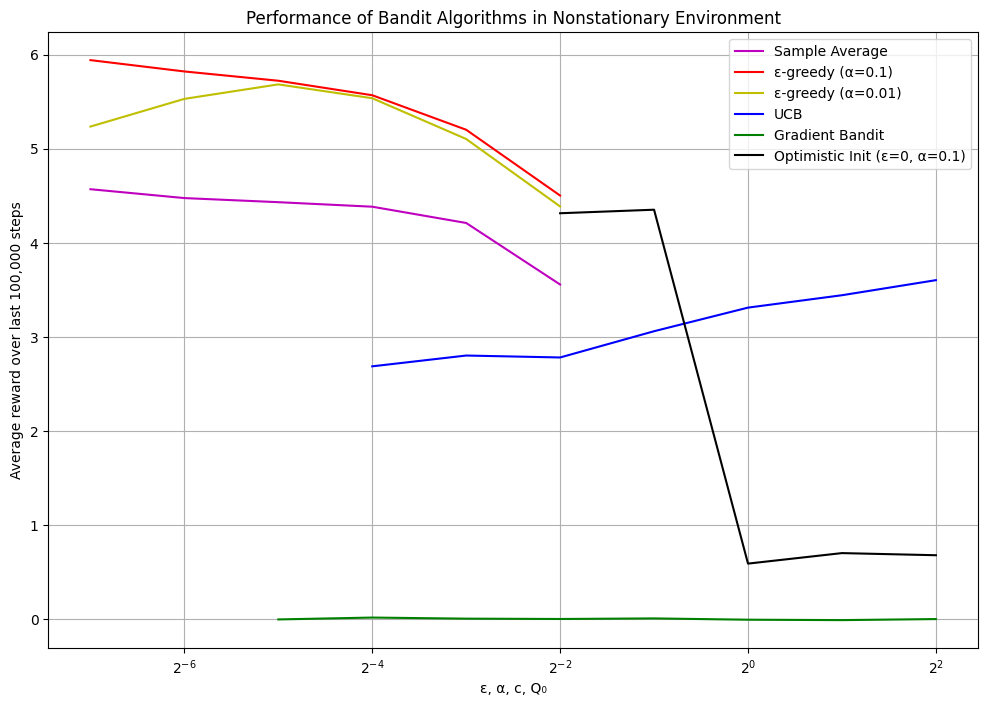

In [19]:
# Plotting
plt.figure(figsize=(12, 8))
plt.semilogx(epsilons, sample_average_rewards, 'm-', label='Sample Average')
plt.semilogx(epsilons, epsilon_greedy_01_rewards, 'r-', label='ε-greedy (α=0.1)')
plt.semilogx(epsilons, epsilon_greedy_001_rewards, 'y-', label='ε-greedy (α=0.01)')
plt.semilogx(cs, ucb_rewards, 'b-', label='UCB')
plt.semilogx(alphas, gradient_rewards, 'g-', label='Gradient Bandit')
plt.semilogx(initial_values, optimistic_rewards, 'k-', label='Optimistic Init (ε=0, α=0.1)')

plt.xlabel('ε, α, c, Q₀')
plt.ylabel('Average reward over last 100,000 steps')
plt.title('Performance of Bandit Algorithms in Nonstationary Environment')

# Set x-axis to log scale
plt.xscale('log', base=2)
plt.legend()
plt.grid(True)

plt.show()